Disclaimer: The following analysis represents the first steps in Python and might therefore contain some not super-efficient lines of code - feedback is always appreciated! :)

##SUBSTATION FAULT DETECTION THROUGH HOURLY METERING DATA

-- WORK IN PROGESS --

A supplemental description of the conducted analysis can be found in the corresponding report and is recommended to be read alongside.

As a first step, all necessary imports had to be done to make analysis accessible.

In [1]:
import pandas as pd
import random, math
from pandas import Series, DataFrame, Panel, Timedelta
from datetime import timedelta
from scipy import optimize
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPRegressor #MLP = Multi Layer Perceptron
from sklearn.neighbors import KNeighborsRegressor
import xlsxwriter
%matplotlib inline
pd.__version__

'0.19.2'

Now, the main data has to be imported with a direct conversion of the given time stamps into a readable format for Python's Pandas package. Further, the read data will be checked for gaps.

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S')
consolidated_df = pd.read_csv ("/Users/Julian/Google Drive/Energy Planning & Applications/Final Project/Detection Tool/measured_values.csv", decimal=",", delimiter=";", parse_dates=["Time_Stamp"], date_parser=dateparse)
print(consolidated_df.shape)

print("# NaN values: " + str(consolidated_df.isnull().sum().sum()))

(26304, 398)
# NaN values: 0


Since it is easier to work with column indices (e.g. when looping through a list), each substation will be substituted by a index. To always backtrack which index belongs to which official ID, also the IDs are imported and checked for NaN values.

In [3]:
#Reading the building IDs (was separated to another excel file)
building_ids_df = pd.read_csv ("/Users/Julian/Google Drive/Energy Planning & Applications/Final Project/Detection Tool/building_ids.csv", decimal=",", delimiter=";")
print(building_ids_df.shape)
#Check if any value is empty/NaN
print("# NaN values: " + str(building_ids_df.isnull().sum().sum()))

(99, 1)
# NaN values: 0


At last, also the outside temperature for each time stamp will be imported to analyze relations and run regressions. Only as a check, the number of rows should equals the number of rows in the main data set to be sure that both are matched correctly: Looks good, both have 26304 rows. However, it can be found there here occur for the first time NaN values.

In [4]:
outside_df = pd.read_csv ("/Users/Julian/Google Drive/Energy Planning & Applications/Final Project/Detection Tool/outside_temperature_jan14-dez16.csv", decimal=",", delimiter=";")
print(outside_df.shape)
print("# NaN values: " + str(outside_df.isnull().sum().sum()))

(26304, 2)
# NaN values: 3


Consequently, the outside temperature contains three emtpy gaps with which have to be dealt with - however, this will be done after getting a basic understanding of the datasets. 

The main dataframe with the measured values for all 99 substation looke like the following (excerpt):

In [5]:
consolidated_df.head()

,Time_Stamp,Fanv_m3,Varm_Temp_C,Kall_Temp_C,Eanv_MWh,Eanv_MWh.1,Fanv_m3.1,Varm_Temp_C.1,Kall_Temp_C.1,Varm_Temp_C.2,...,Varm_Temp_C.96,Eanv_MWh.97,Varm_Temp_C.97,Kall_Temp_C.97,Fanv_m3.97,Varm_Temp_C.98,Kall_Temp_C.98,Fanv_m3.98,Eanv_MWh.98,Unnamed: 397
0,2014-01-01 00:00:00,1.16,75,35,0.053,0.47,10.0,76,35,79.8,...,77.7,0.024,77,53,0.83,76.8,40.3,4.46,0.195,Avläst
1,2014-01-01 01:00:00,1.15,76,31,0.051,0.46,9.8,75,33,86.3,...,78.3,0.025,76,51,0.84,75.7,39.6,4.78,0.204,Avläst
2,2014-01-01 02:00:00,1.18,75,38,0.052,0.45,9.5,76,37,88.6,...,85.0,0.028,77,49,0.86,76.5,39.3,4.36,0.179,Avläst
3,2014-01-01 03:00:00,1.11,76,39,0.048,0.43,8.5,77,37,87.9,...,88.3,0.019,78,53,0.64,76.1,40.0,4.08,0.173,Avläst
4,2014-01-01 04:00:00,1.08,77,39,0.049,0.42,8.3,79,36,89.2,...,87.8,0.017,80,53,0.53,75.8,39.6,4.07,0.175,Avläst


As can be seen in the column titles of the previous data frame, the titles for the same measured parameter are the same for the same for all substations, only a number is added to make it each column title unique. As this is not really handy to work with, the entire dataframe will be split into 99 sub-dataframes which are all stored in a list. In each of the list elements is a dataframe with the same column titles. Also, the index of a substation in the list will be used later on with the dataframe "building_ids" to retrieve the actual building ID.

So the following is done:
1. Split entrie dataframe into 99 sub-dataframes and store these in one list
2. Rename the column titles of each sub-dataframes consistently

In [6]:
#Create Sub-Dataframes - one for each substation - and add them to a list for all substations
iterator = 1
houses = [] #List of dataframes
for i in range (0, 99): #99 households to be observed
    
    #Add measured values
    houses.append(consolidated_df.iloc[:,[0, iterator, iterator + 1, iterator + 2, iterator + 3]])
    iterator = iterator + 4
    
    #Rename column titles as they are in changing order and with varying names (due to import)
    houses[i].columns = houses[i].columns.str.replace("Time_Stamp", "Time stamp")
    #No-wildcard cases
    houses[i].columns = houses[i].columns.str.replace("Eanv_MWh", "Energy_MWh/h")
    houses[i].columns = houses[i].columns.str.replace("Fanv_m3", "Mass flow_m3/h")
    houses[i].columns = houses[i].columns.str.replace("Varm_Temp_C", "T supply_C")
    houses[i].columns = houses[i].columns.str.replace("Kall_Temp_C", "T return_C")
    #1 wildcard cases
    houses[i].columns = houses[i].columns.str.replace(".*Energy_MWh/h*.", "Energy_MWh/h")
    houses[i].columns = houses[i].columns.str.replace(".*Mass flow_m3/h*.", "Mass flow_m3/h")
    houses[i].columns = houses[i].columns.str.replace(".*T supply_C*.", "T supply_C")
    houses[i].columns = houses[i].columns.str.replace(".*T return_C*.", "T return_C")
    #2 wildcard cases
    houses[i].columns = houses[i].columns.str.replace(".*Energy_MWh/h*..", "Energy_MWh/h")
    houses[i].columns = houses[i].columns.str.replace(".*Mass flow_m3/h*..", "Mass flow_m3/h")
    houses[i].columns = houses[i].columns.str.replace(".*T supply_C*..", "T supply_C")
    houses[i].columns = houses[i].columns.str.replace(".*T return_C*..", "T return_C")
    #3 wildcard cases
    houses[i].columns = houses[i].columns.str.replace(".*Energy_MWh/h*...", "Energy_MWh/h")
    houses[i].columns = houses[i].columns.str.replace(".*Mass flow_m3/h*...", "Mass flow_m3/h")
    houses[i].columns = houses[i].columns.str.replace(".*T supply_C*...", "T supply_C")
    houses[i].columns = houses[i].columns.str.replace(".*T return_C*...", "T return_C")
    
    #Adding outside temperature
    houses[i]["T outside_C"] = outside_df.iloc[:,[1]]
    
    #Adding temperature difference
    houses[i]["T difference_C"] = houses[i]["T supply_C"].sub(houses[i]["T return_C"], axis=0)

    #Bringing all columns into the same order
    houses[i] = houses[i] [["Time stamp", "T outside_C", "T difference_C", "T supply_C", "T return_C", "Energy_MWh/h", "Mass flow_m3/h"]]

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A quick check to see how it works - looks fine...

In [7]:
houses[9]

,Time stamp,T outside_C,T difference_C,T supply_C,T return_C,Energy_MWh/h,Mass flow_m3/h
0,2014-01-01 00:00:00,2.9,46.5,82.7,36.2,0.204,3.81
1,2014-01-01 01:00:00,2.8,47.0,81.4,34.4,0.206,4.01
2,2014-01-01 02:00:00,3.2,45.9,78.5,32.6,0.176,3.48
3,2014-01-01 03:00:00,3.6,45.7,80.8,35.1,0.163,3.06
4,2014-01-01 04:00:00,3.0,45.5,81.5,36.0,0.192,3.56
5,2014-01-01 05:00:00,2.7,46.5,84.1,37.6,0.205,3.66
6,2014-01-01 06:00:00,2.7,46.9,84.7,37.8,0.181,3.30
7,2014-01-01 07:00:00,2.7,47.7,84.7,37.0,0.186,3.35
8,2014-01-01 08:00:00,3.0,47.8,84.3,36.5,0.194,3.43
9,2014-01-01 09:00:00,3.1,50.9,83.7,32.8,0.205,3.39


Next, the whole 99 sub-dataframes will be changed to time-series format to make it easier to work with and to have the ability to easily drill into specific days/weeks/months etc.

In [8]:
date_range = pd.date_range("1/1/2014 00:00:00", "12/31/2016 23:00:00", freq="H")

variable = "T difference_C"
houses_series = [] #List which all columns of certain variable (in Series format) from all houses 
for i in range (0,99):
        #Create deep copy of raw data
        houses_series.append(houses[i].copy(deep=True))
        #Create out of each dataframe a time series with the column specified in 'variable'
        houses_series[i] = Series(houses_series[i][variable].values, index=date_range)
        
t_difference_series = []
for i in range (0,99):
        #Create deep copy of raw data
        t_difference_series.append(houses[i].copy(deep=True))
        #Create out of each dataframe a time series with the column specified in 'variable'
        t_difference_series[i] = Series(t_difference_series[i]["T difference_C"].values, index=date_range)
        
t_supply_series = []
for i in range (0,99):
        #Create deep copy of raw data
        t_supply_series.append(houses[i].copy(deep=True))
        #Create out of each dataframe a time series with the column specified in 'variable'
        t_supply_series[i] = Series(t_supply_series[i]["T supply_C"].values, index=date_range)
        
t_return_series = []
for i in range (0,99):
        #Create deep copy of raw data
        t_return_series.append(houses[i].copy(deep=True))
        #Create out of each dataframe a time series with the column specified in 'variable'
        t_return_series[i] = Series(t_return_series[i]["T return_C"].values, index=date_range)
        
energy_series = []
for i in range (0,99):
        #Create deep copy of raw data
        energy_series.append(houses[i].copy(deep=True))
        #Create out of each dataframe a time series with the column specified in 'variable'
        energy_series[i] = Series(energy_series[i]["Energy_MWh/h"].values, index=date_range)
        
mass_flow_series = []
for i in range (0,99):
        #Create deep copy of raw data
        mass_flow_series.append(houses[i].copy(deep=True))
        #Create out of each dataframe a time series with the column specified in 'variable'
        mass_flow_series[i] = Series(mass_flow_series[i]["Mass flow_m3/h"].values, index=date_range)

And also for the dataframe containing the outside temperature

In [9]:
outside_series = Series(outside_df ["T outside_C"].values, index=date_range)

After transforming all the data into an easier-to-use format of a time series, the actual analysis can begin in which we first look into the specific dates that Fortum provided for some of the selected substation.

To reveal abnormal behaviour in any of the variables, all of the marked ones were ploted and analyzed (to keep this notebook at an acceptable length, only a subset of the plots are shown). Since energy is only a result of mass flow and temperature difference, energy will be left out.

The following plot shows substation 5 (ID 10302) from July 25-30, 2015.

(most of the code below is actually only to achieve a certain plot layout and to save the plot to a high resolution file - similar for the following plots)

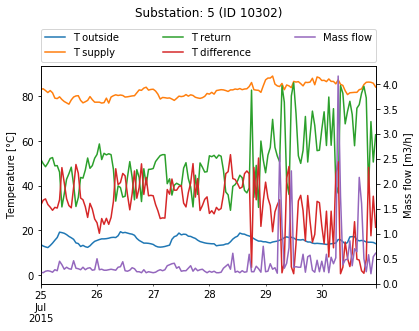

In [10]:
x1 = "2015-7-25"
x2 = "2015-7-30"
id = 5
df = pd.concat([outside_series[x1:x2],
                t_supply_series[id][x1:x2],
                t_return_series[id][x1:x2],
                t_difference_series[id][x1:x2],
                mass_flow_series[id][x1:x2]], axis=1)
df.columns = ["T outside", "T supply", "T return", "T difference", "Mass flow"]
plt.figure()
ax = df.plot(secondary_y=["Mass flow"], mark_right = False)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")
ax.right_ax.set_ylabel("Mass flow [m3/h]")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
#lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(1.15, 0), loc=3, borderaxespad=0.)
plt.savefig("substation" + str(id) + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

The following plot shows substation 8 (ID 10477) from October 22-30, 2016.

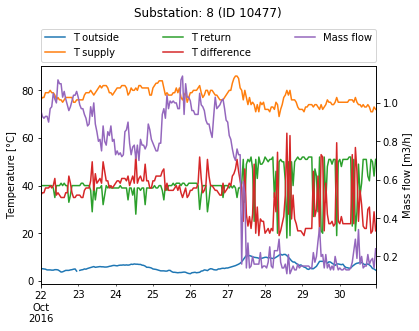

In [11]:
x1 = "2016-10-22"
x2 = "2016-10-30"
id = 8
df = pd.concat([outside_series[x1:x2],
                t_supply_series[id][x1:x2],
                t_return_series[id][x1:x2],
                t_difference_series[id][x1:x2],
                mass_flow_series[id][x1:x2]], axis=1)
df.columns = ["T outside", "T supply", "T return", "T difference", "Mass flow"]
plt.figure()
ax = df.plot(secondary_y=["Mass flow"], mark_right = False)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")
ax.right_ax.set_ylabel("Mass flow [m3/h]")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
#lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(1.15, 0), loc=3, borderaxespad=0.)
plt.savefig("substation" + str(id) + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

The following plot shows substation 12 (ID 11184) from January 1-2, 2014.

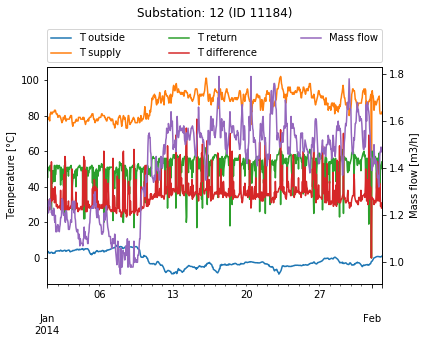

In [12]:
x1 = "2014-1-1"
x2 = "2014-2-1"
id = 12
df = pd.concat([outside_series[x1:x2],
                t_supply_series[id][x1:x2],
                t_return_series[id][x1:x2],
                t_difference_series[id][x1:x2],
                mass_flow_series[id][x1:x2]], axis=1)
df.columns = ["T outside", "T supply", "T return", "T difference", "Mass flow"]
plt.figure()
ax = df.plot(secondary_y=["Mass flow"], mark_right = False)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")
ax.right_ax.set_ylabel("Mass flow [m3/h]")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
#lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(1.15, 0), loc=3, borderaxespad=0.)
plt.savefig("substation" + str(id) + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

The following plot shows substation 18 (ID 11383) from August 20, 2016 to December 31, 2016.

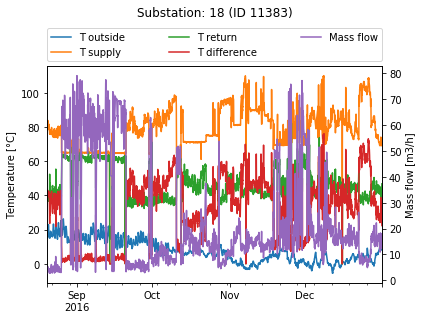

In [13]:
x1 = "2016-8-20"
x2 = "2016-12-31"
id = 18
df = pd.concat([outside_series[x1:x2],
                t_supply_series[id][x1:x2],
                t_return_series[id][x1:x2],
                t_difference_series[id][x1:x2],
                mass_flow_series[id][x1:x2]], axis=1)
df.columns = ["T outside", "T supply", "T return", "T difference", "Mass flow"]
plt.figure()
ax = df.plot(secondary_y=["Mass flow"], mark_right = False)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")
ax.right_ax.set_ylabel("Mass flow [m3/h]")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
#lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(1.15, 0), loc=3, borderaxespad=0.)
plt.savefig("substation" + str(id) + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

Based on the analysis of these plots and corresponding physical relations, we decided to go on from here with the temperature as the characteristic measure for inefficiency in substation systems (for further ellaboration on this matter, please refer to the final project report).

However, since the temperature is always subject to some fluctuation it was necessary to develop a generalization to determine what level of fluctuation of the temperature difference is normal or abnormal respectively.

We started off with the mean as the most obvious way of generalization...

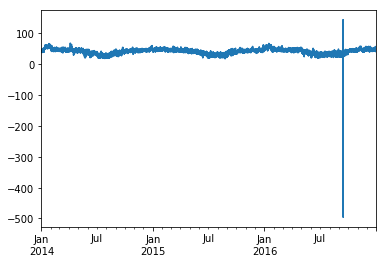

In [14]:
houses_series = pd.concat(houses_series, axis = 1)
mean = houses_series.mean(axis=1) #row-wise (per time stamp) mean
mean.plot()

...however we soon encountered here the typical weakness of the mean with its sensitivity to outliers. By looking deeper into the data, we discovered substations with an abnormaly high standard deviation (e.g. no 35 with approx  328 in contrast to approx 10-15 what seems to be the average).

In [15]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
houses_series.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
count,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.00000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000
mean,37.511937,43.724491,50.753505,39.198552,37.760656,43.807607,41.979649,42.267005,34.610820,55.643222,33.113283,50.422179,23.102038,43.687903,41.213488,52.073913,35.394788,41.226467,41.999384,48.886861,37.798122,39.836485,48.180379,38.584854,43.076300,35.481976,35.107600,48.884056,36.340868,49.908265,51.772354,46.150369,36.992416,42.213884,45.938412,35.993687,41.876825,46.523114,35.249555,41.766940,48.650487,34.612424,38.813108,44.244297,40.186512,34.799981,37.442936,38.833349,48.163641,40.61707,38.101893,37.398175,26.993560,39.279334,26.161724,34.833546,46.174840,34.396495,42.946240,43.603520,41.446928,42.080870,45.547008,38.815446,41.611850,35.059155,41.253239,43.214583,32.932417,31.709801,38.275513,24.892309,39.881691,38.566796,39.611356,40.055060,37.362032,46.027178,35.636238,47.070951,41.369803,39.712401,43.742583,45.468788,41.072841,43.948468,38.854623,36.234713,31.273696,43.880436,39.293522,35.018514,40.085690,44.544590,61.361074,43.632839,47.273175,39.561854,39.068225
std,13.399971,9.598261,12.102639,11.584832,10.450173,16.039643,11.335197,9.651665,11.721922,10.853265,10.133837,9.892408,14.773184,9.058541,11.235388,10.598040,9.571271,7.908498,15.183550,10.012491,11.154227,7.889569,13.297316,9.612653,12.904411,10.959114,9.154601,8.799404,11.273227,9.010079,15.504717,10.404457,11.896610,8.317858,13.049234,328.596093,11.324492,8.514027,9.839662,10.769014,8.421215,15.980949,10.283487,10.442795,15.443066,9.596683,16.257478,11.124895,8.598441,7.55999,11.207667,9.658341,20.643719,10.651802,12.225340,7.451691,10.707886,8.527781,10.345037,64.304721,10.561299,9.866516,10.397075,9.766995,8.911041,10.273117,11.555200,11.961655,14.104113,14.518001,10.510886,16.523447,12.503458,12.986083,9.558754,10.437486,11.995703,9.747440,14.630588,11.015106,10.462844,11.917311,9.456873,11.719391,7.841840,11.102261,13.780830,15.764820,10.467565,10.996028,10.769301,12.507249,12.283994,10.298809,9.404536,12.043199,10.415847,12.743414,8.429196
min,-16.000000,0.000000,0.000000,-0.400000,-13.000000,-11.000000,0.000000,-8.000000,0.000000,0.000000,-43.300000,0.000000,-1.000000,0.000000,0.000000,-1.300000,0.000000,0.000000,0.000000,-21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-53229.870000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,-21.000000,0.000000,0.000000,-11.000000,0

In order make our generalization more robust against outliers, we continued with the median as very large numbers don't affect the median as much as they would affect the mean. The following plot shows in blue the hourly median temperature difference of all 99 substations. In orange and green are the median +/- 1 MAD plotted.

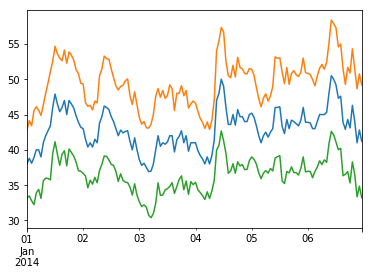

In [16]:
median = houses_series.median(axis=1)
mad = houses_series.mad(axis=1)

x1 = "2014-1-1"
x2 = "2014-1-6"
median[x1:x2].plot()
(median[x1:x2]+mad[x1:x2]).plot()
(median[x1:x2]-mad[x1:x2]).plot()

So let's see how the median looks like as generalization in a plot with a proper working station (#1, ID 10118, January 2016), for simplicity only with the temperature difference and the outside temperature...

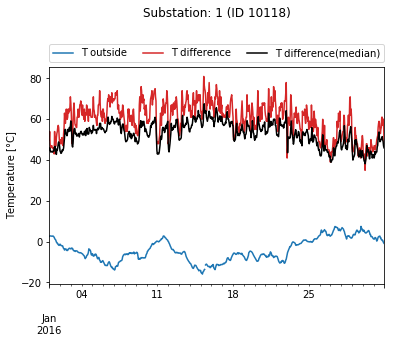

In [17]:
x1 = "2016-1"
x2 = "2016-1"
id = 1
df = pd.concat([outside_series[x1:x2],
                t_difference_series[id][x1:x2],
                median[x1:x2]], axis=1)
df.columns = ["T outside", "T difference", "T difference(median)"]
color = ["#1f77b4", "#d62728", "black"]
plt.figure()
ax = df.plot(color=color)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")
lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
#plt.savefig("substation" + str(id) + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

... and for a broken one

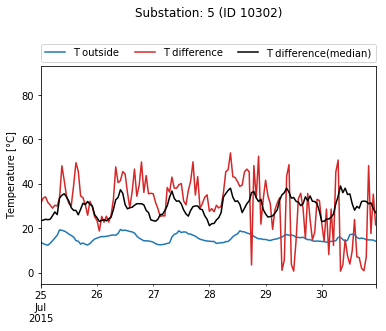

In [18]:
x1 = "2015-7-25"
x2 = "2015-7-30"
id = 5
df = pd.concat([outside_series[x1:x2],
                t_difference_series[id][x1:x2],
                median[x1:x2]], axis=1)
df.columns = ["T outside", "T difference", "T difference(median)"]
color = ["#1f77b4", "#d62728", "black"]
plt.figure()
ax = df.plot(color=color)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")
plt.ylim(-5,93)
plt.yticks(np.arange(0, 81, 20))
lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
#plt.savefig("substation" + str(id) + "_withoutMedian" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

(the following plot is the same as the previous one, only without the outside temperature as simplification, used for the final presentation)

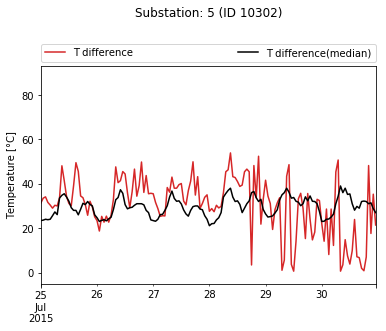

In [19]:
x1 = "2015-7-25"
x2 = "2015-7-30"
id = 5
df = pd.concat([t_difference_series[id][x1:x2], median[x1:x2]], axis=1)
df.columns = ["T difference", "T difference(median)"]
plt.figure()
color = ["#d62728", "black"]
ax = df.plot(color=color)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")
plt.ylim(-5,93)
plt.yticks(np.arange(0, 81, 20))
lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.savefig("substation" + str(id) + "_withMedian_2" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

After a better understanding of the parameters and their behaviour was acquired, a way was tried to be implemented about how to seperate alarming from non-alarming deviations.

For this reason, the hourly deviation of each substation from the hourly median was calculated. In order to test this approach first on a smaller scale, this was only done for the first 500 time stamps starting from January 10, 2014 00:00.

The output of this cell list the numbers of the substations with the highest deviation in this time span in descending order.

In [20]:
deviation_vector = np.ndarray(shape=(99,2), dtype=float)
deviation_vector.fill(0)
input_vector = np.ndarray(shape=(99,2), dtype=float)
output_vector = np.ndarray(shape=(99,2), dtype=float)
date_iter = pd.Timestamp("2014-1-10 00:00")
Timedelta(hours=1)

for i in range (0,500): #To advance on hourly basis
    
    #Pull data for this certain day
    for i in range (0,99):
        #Pull data for this certain day
        input_vector [i][0] = outside_series[date_iter]
        input_vector [i][1] = t_difference_series[i][date_iter]
        
    #Pull data for this certain day
    for i in range (0,99):
        #Calculate deviation from KNN regressin 
        #output_vector [i][0] = knn.predict(input_vector[i][0])
        
        #Calculate deviation from hourly median value
        output_vector [i][0] = np.median(input_vector [:,1], axis=0)
        output_vector [i][1] = t_difference_series[i][date_iter]
        #Deviation: If positive, actual value lower than predicted (vice versa)
        deviation_vector [i][0] =  deviation_vector [i][0] + (output_vector [i][0] - output_vector [i][1])
    date_iter = date_iter + pd.Timedelta(hours=1)
    
def get_indices(a,N):
    return np.argsort(a)[::-1][:N]
print(get_indices(deviation_vector[:,0],99))

[91 51 12 42 55  7 73  4 57 54 38 21 39 37 26 53 50 33 69 63 35 45 32 16 14
 41 49 25  5 31 97 13 27 23 36 71 58 88  9 10 78 11 56 18 52 70 19 74 47 24
 20 48 84  8 46 65 80 44 98 64 92 60 93 43 87 76 17  2 40 82  0 28 66 90 59
 68 81 86 34 29 75 77 72 67 96 15 61 22 89 85  3 79  6  1 62 83 30 94 95]


To expand this approach on the whole dataset, this was done similarly for all 99 substations starting from January 1, 2014 00:00 and all accessible time stamps (26304 in total).

The resulting array "hourly_deviation_array" consequently contains for for each time stamp (26304 in total) and for each substation (99 in total) the current deviation from the hourly median temperature.

In [21]:
#Calculation of every ID per hour
deviation_vector = np.ndarray(shape=(1,99), dtype=float)
deviation_vector.fill(0)
hourly_deviation_array = np.ndarray(shape=(0,99))
hourly_deviation_array.fill(0)
input_vector = np.ndarray(shape=(99,2), dtype=float)
output_vector = np.ndarray(shape=(99,2), dtype=float)
date_iter = pd.Timestamp("2014-1-1 00:00")
Timedelta(hours=1)

for i in range (0,26304): #To advance on hourly basis until end
    
    #Pull data for this certain day
    for i in range (0,99):
        input_vector [i][0] = outside_series[date_iter]
        input_vector [i][1] = t_difference_series[i][date_iter]
        
    #Pull data for this certain day
    for i in range (0,99):
        #Calculate deviation from KNN regressin 
        #output_vector [i][0] = knn.predict(input_vector[i][0])
        
        #Calculate deviation from hourly median value
        output_vector [i][0] = np.median(input_vector [:,1], axis=0)
        output_vector [i][1] = t_difference_series[i][date_iter]
        #Deviation: If positive, actual value lower than predicted (vice versa)
        deviation_vector [0][i] =  (output_vector [i][0] - output_vector [i][1])
    date_iter = date_iter + pd.Timedelta(hours=1)
    #Add vector to array
    hourly_deviation_array = np.append(hourly_deviation_array, deviation_vector, axis=0)

Quick check to make sure that the array has the right shape - looks fine...

In [22]:
hourly_deviation_array.shape

(26304, 99)

Based on the resulting "hourly_deviation_array", the cumulative sum will be calculated for a time span of 10 hours in order to account for the frequency of high deviations.

In [23]:
span = 10 #last 71 values + current one
span_deviation_array = np.ndarray(shape=hourly_deviation_array.shape)
span_deviation_array.fill(0)
buffersum = 0.0

for i in range (0,len(span_deviation_array)):
    for j in range (0,len(span_deviation_array[i])):
        for k in range(0,span):
            if i-span+1+k >= 0:
                buffersum = buffersum + hourly_deviation_array[i-span+1+k][j]
            
        span_deviation_array [i][j] = buffersum
        buffersum = 0.0

To check also manually if the calculations worked the way they were intended to work, here with the example of the substation with list index 97.

The temperature difference on December 31, 2016 at 23:00 is 39°C...

In [24]:
t_difference_series[97]["2016-12-31"]

2016-12-31 00:00:00    73
2016-12-31 01:00:00    51
2016-12-31 02:00:00    53
2016-12-31 03:00:00    34
2016-12-31 04:00:00    46
2016-12-31 05:00:00    39
2016-12-31 06:00:00    37
2016-12-31 07:00:00    41
2016-12-31 08:00:00    67
2016-12-31 09:00:00    80
2016-12-31 10:00:00    81
2016-12-31 11:00:00    66
2016-12-31 12:00:00    76
2016-12-31 13:00:00    55
2016-12-31 14:00:00    71
2016-12-31 15:00:00    62
2016-12-31 16:00:00    76
2016-12-31 17:00:00    64
2016-12-31 18:00:00    61
2016-12-31 19:00:00    48
2016-12-31 20:00:00    50
2016-12-31 21:00:00    61
2016-12-31 22:00:00    59
2016-12-31 23:00:00    39
Freq: H, dtype: int64

... and the median temperature measured at the same point of time was 42°C...

In [25]:
median["2016-12-31"]

2016-12-31 00:00:00    46.9
2016-12-31 01:00:00    45.3
2016-12-31 02:00:00    44.9
2016-12-31 03:00:00    44.0
2016-12-31 04:00:00    44.0
2016-12-31 05:00:00    44.9
2016-12-31 06:00:00    45.3
2016-12-31 07:00:00    46.5
2016-12-31 08:00:00    48.1
2016-12-31 09:00:00    52.7
2016-12-31 10:00:00    57.0
2016-12-31 11:00:00    56.3
2016-12-31 12:00:00    55.0
2016-12-31 13:00:00    57.0
2016-12-31 14:00:00    51.0
2016-12-31 15:00:00    52.6
2016-12-31 16:00:00    54.2
2016-12-31 17:00:00    50.0
2016-12-31 18:00:00    49.1
2016-12-31 19:00:00    46.0
2016-12-31 20:00:00    45.1
2016-12-31 21:00:00    43.3
2016-12-31 22:00:00    44.4
2016-12-31 23:00:00    42.0
Freq: H, dtype: float64

... consequently the deviation of the second last substation (as substation indexing started at 0) for the last available time stamp is 42°C - 39°C = 3°C, which can be also found in the last shown table below as the second last value...

In [26]:
hourly_deviation_array 

array([[ -2. ,  -3. ,  -7.6, ...,  -5.7,  14. ,   1.5],
       [ -6.2,  -3.2, -13.2, ...,  -4.9,  13.8,   2.7],
       [  1.1,  -0.9, -17.5, ..., -13. ,  10.1,   0.9],
       ..., 
       [ -1.7,  -0.7,  -0.4, ...,  -1.7, -17.7,   4.2],
       [ -3.6,  -3.6, -14.8, ...,   4. , -14.6,   4.7],
       [ -9. ,  -1. ,   8.3, ...,  -0.7,   3. ,   4.2]])

For some reason as before to make the data easier to handle, the hourly deviation as well as the span deviation of (span = 10 hours) will be converted into time series format.

In [27]:
#Change both into list of time series to make them easier plotable 
hourly_deviation_series = []
span_deviation_series = []
for i in range (0,99):
        #Create copy
        hourly_deviation_series.append(hourly_deviation_array[:,i])
        span_deviation_series.append(span_deviation_array[:,i])
        #Change element in each list entry into series
        hourly_deviation_series [i] = Series(hourly_deviation_series [i], index=date_range)
        span_deviation_series [i] = Series(span_deviation_series [i], index=date_range)

An example of how these time series look like for a specific problematic substation can be found in the following plot for substation with list index 18 from August 23 to December 28, 2016.

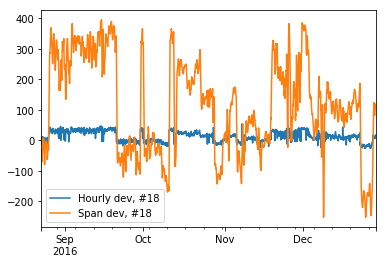

In [28]:
x1 = "2016-8-23"
x2 = "2016-12-28"
id = 18
hourly_deviation_series [id][x1:x2].plot(legend=True, label = "Hourly dev, #" + str(id))
span_deviation_series [id][x1:x2].plot(legend=True, label = "Span dev, #" + str(id))

(the following plot was only created and saved to provide a simplyfied example for the final presentation; substation ID 10302 represents a problematic one)

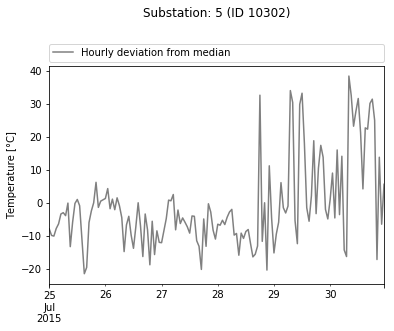

In [29]:
x1 = "2015-7-25"
x2 = "2015-7-30"
id = 5
df = pd.concat([hourly_deviation_series [id][x1:x2]], axis=1)
df.columns = ["Hourly deviation from median"]
plt.figure()
ax = df.plot(color="grey")
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")

lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.savefig("substation" + str(id) + "_deviationFromMedian" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

(the following plot was only created and saved to provide a simplyfied example for the final presentation; substation ID 10477 represents also problematic one)

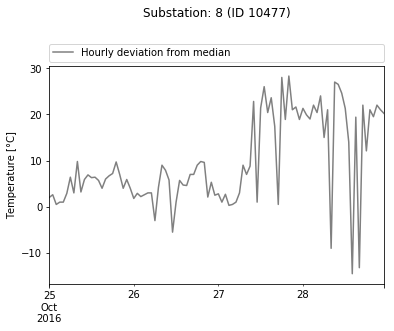

In [33]:
x1 = "2016-10-25"
x2 = "2016-10-28"
id = 8
df = pd.concat([hourly_deviation_series [id][x1:x2]], axis=1)
df.columns = ["Hourly deviation from median"]
plt.figure()
ax = df.plot(color="grey")
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")

lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.savefig("substation" + str(id) + "_highSuddenDeviation" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

A combined two-axis plot for substation 5 (ID 10302) to showcase the behavior of the different parameters can be found as the output of the following cell.

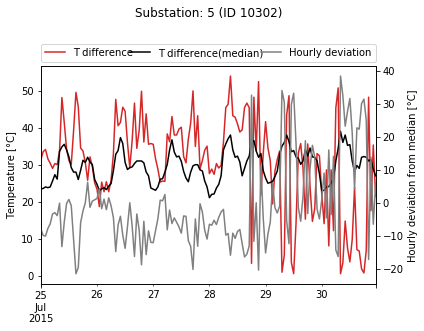

In [34]:
x1 = "2015-7-25"
x2 = "2015-7-30"
id = 5
df = pd.concat([t_difference_series[id][x1:x2],
                median[x1:x2],
                hourly_deviation_series [id][x1:x2]], axis=1)
df.columns = ["T difference", "T difference(median)", "Hourly deviation"]
plt.figure()
color = ["#d62728", "black", "grey"]
ax = df.plot(secondary_y=["Hourly deviation"], mark_right = False, color=color)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")
ax.right_ax.set_ylabel("Hourly deviation from median [°C]")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
#lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(1.15, 0), loc=3, borderaxespad=0.)
#plt.savefig("substation" + str(id) + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

In addition to the previously plotted development of the hourly deviation for sustation 8 (ID 10477) does the following also show the development of the cumulated deviation with a span-paramter of 10 hours from October 25-28, 2016.

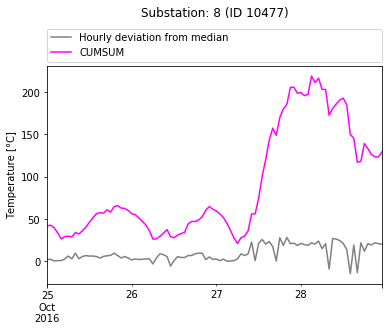

In [35]:
x1 = "2016-10-25"
x2 = "2016-10-28"
id = 8
df = pd.concat([hourly_deviation_series [id][x1:x2],span_deviation_series [id][x1:x2]], axis=1)
df.columns = ["Hourly deviation from median", "CUMSUM"]
plt.figure()
color = ["grey", "magenta"]
ax = df.plot(color=color)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")

lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.savefig("substation" + str(id) + "_cumSum" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

And similarly for substation 9 (ID 10883) from July 1-10, 2016...

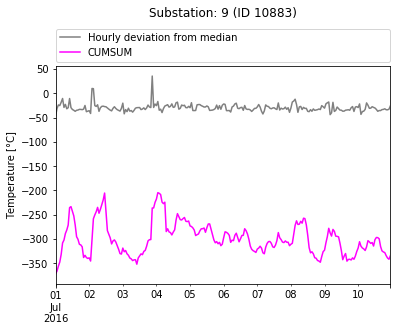

In [36]:
x1 = "2016-7-1"
x2 = "2016-7-10"
id = 9
df = pd.concat([hourly_deviation_series [id][x1:x2],span_deviation_series [id][x1:x2]], axis=1)
df.columns = ["Hourly deviation from median", "CUMSUM"]
plt.figure()
color = ["grey", "magenta"]
ax = df.plot(color=color)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")

lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.savefig("substation" + str(id) + "_cumSum" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

In order to make the calculated values also accessible and editable for anyone without Python knowledge, an export to Excel a .xls-file will be conducted.

For this reason, some data-type conversions are necessary...

In [37]:
building_ids_df.as_matrix() [1] [0]
span_deviation_df = pd.DataFrame({"Time stamp":consolidated_df["Time_Stamp"]})
for i in range (0,len(span_deviation_array[i])):
        span_deviation_df[building_ids_df.as_matrix()[i][0]] = span_deviation_array[:,i]

To check if the created dataframe has the desired properties...

In [38]:
span_deviation_df.head()

,Time stamp,10006,10118,10249,10264,10284,10302,10308,10344,10477,10883,11122,11146,11184,11345,11349,11367,11376,11380,11383,11413,11418,11509,11607,11608,11633,11686,11709,11720,11779,11782,11888,12098,12117,12248,12310,12408,12409,12495,12497,12501,12791,12813,12930,12998,13178,13232,13237,13333,13359,13424,13459,13755,13763,13773,13809,14052,14068,14098,14113,8236,8238,8243,8251,8283,8289,8299,8347,8366,8371,8380,8404,8405,8407,8447,8449,8471,8619,8658,8682,8724,8762,8790,8824,8851,8872,8874,8888,8892,8972,8977,8988,9021,9040,9041,9843,9867,9904,9916,9943
0,2014-01-01 00:00:00,-2.0,-3.0,-7.6,-4.1,1.9,-2.0,8.2,6.3,2.0,-8.5,8.2,1.0,9.0,-3.6,-2.3,-5.1,5.1,4.0,-14.2,-3.0,6.5,-5.1,-12.9,2.0,-4.0,2.1,8.8,2.6,-1.0,-9.0,-29.0,-2.3,-1.6,1.1,-10.5,0.0,1.0,0.0,7.5,4.0,-2.0,2.0,7.0,-5.0,11.3,0.0,-6.0,-1.3,-7.2,7.3,1.1,15.2,-10.9,-1.0,-1.8,6.1,-6.0,1.5,-1.4,3.1,4.0,0.3,-2.0,2.7,6.0,0.0,3.2,5.0,-2.5,9.0,5.2,2.3,-1.0,1.0,2.9,-1.8,0.0,-0.2,3.6,-6.2,2.2,-4.7,-0.1,-2.0,5.0,-1.0,0.0,4.6,3.4,2.0,3.0,36.0,-5.0,-7.5,-10.4,-1.0,-5.7,14.0,1.5
1,2014-01-01 01:00:00,-8.2,-6.2,-20.8,-7.5,1.4,-5.8,10.4,14.8,3.8,-16.7,14.7,0.8,14.8,-7.8,-4.0,-18.2,10.9,5.8,-44.4,-8.2,6.4,-10.2,-30.8,8.8,-9.2,2.2,17.5,5.4,-1.2,-13.2,-57.2,-10.7,-3.9,1.0,-19.9,-0.2,2.8,1.8,14.5,5.8,-2.2,3.8,14.8,-12.2,24.5,-1.3,-11.2,-10.2,-12.4,12.9,-0.1,26.9,-19.9,-0.9,-1.8,7.6,-12.2,4.5,-3.1,6.5,6.8,-7.9,-3.3,6.2,11.6,0.8,6.4,8.8,-4.5,19.1,-0.7,4.6,-7.2,2.8,5.5,-4.2,0.5,1.8,9.6,-12.4,3.3,-8.4,0.0,-2.2,9.8,-0.2,0.8,6.3,8.4,3.8,3.8,71.8,-9.2,-18.9,-24.6,-3.9,-10.6,27.8,4.2
2,2014-01-01 02:00:00,-7.1,-7.1,-38.3,-9.6,3.9,-7.1,18.0,23.0,5.9,-24.5,22.4,-0.1,23.9,-14.2,-9.3,-34.3,16.8,8.9,-62.2,-14.1,11.3,-14.8,-47.1,11.9,-14.1,3.0,23.6,7.0,-1.1,-18.1,-88.1,-10.9,-5.0,-0.6,-28.8,-1.1,0.9,3.9,21.6,10.9,-9.1,4.9,17.9,-16.1,32.5,-1.3,-22.1,-12.9,-17.1,21.9,-2.8,41.1,-38.3,-1.4,-1.6,9.0,-18.1,7.7,-7.7,9.3,9.9,-7.5,-7.5,7.6,16.9,0.9,4.1,7.9,-6.8,26.4,1.1,7.0,-9.1,3.9,3.5,-6.5,0.6,3.1,13.4,-19.3,5.9,-12.7,-4.0,-4.1,12.9,-0.1,0.9,11.5,12.9,-6.1,6.9,108.9,-14.1,-29.4,-40.1,-5.2,-23.6,37.9,5.1
3,2014-01-01 03:00:00,-5.2,-8.2,-52.5,-12.6,2.5,-11.8,24.5,20.0,8.8,-31.3,29.1,-7.2,34.8,-16.8,-9.2,-47.9,20.5,12.8,-87.3,-18.2,13.9,-19.4,-59.4,18.8,-17.2,0.8,35.5,11.1,-0.2,-23.2,-136.2,-22.1,-5.0,2.2,-37.1,-0.2,-6.2,-4.2,30.0,11.8,-17.2,5.8,24.8,-26.2,42.6,0.9,-30.2,-12.9,-24.0,31.3,-7.2,57.3,-49.6,-12.7,-2.8,14.1,-25.2,9.7,-13.6,12.3,13.8,-6.8,-13.3,13.1,19.4,1.8,8.0,6.8,-7.7,35.7,5.7,9.0,-9.2,42.8,6.3,-9.1,1.3,3.8,18.8,-31.0,7.9,-17.8,-4.5,-7.2,16.8,-8.2,1.8,13.6,18.2,-15.2,9.8,146.8,-18.2,-36.0,-65.7,-7.1,-35.8,51.8,7.9
4,2014-01-01 04:00:00,-3.2,-11.2,-67.4,-16.8,4.8,-21.3,31.7,17.9,10.8,-36.8,33.5,-17.2,46.8,-21.8,-10.9,-62.1,18.3,14.8,-114.7,-24.2,18.4,-23.3,-72.4,24.8,-20.2,4.0,48.7,14.7,-0.2,-28.2,-188.2,-21.7,-5.4,3.4,-45.0,-2.2,-3.2,-3.2,38.7,17.8,-19.2,6.8,35.8,-29.2,38.8,5.3,-38.2,-12.7,-27.6,42.0,-6.7,73.2,-55.8,-9.7,21.1,22.6,-35.2,14.8,-13.9,8.8,15.8,-7.3,-17.0,18.1,25.3,6.8,10.8,4.8,-9.0,45.2,8.9,10.6,-12.2,43.8,9.3,-13.2,0.3,5.5,25.9,-37.1,7.1,-23.4,-6.3,-8.2,21.8,-14.2,1.8,17.1,23.9,-19.2,12.8,185.8,-21.2,-43.7,-85.1,-9.3,-46.2,64.8,11.7


... and also checking the length to be sure...

In [39]:
len(span_deviation_df.index)

26304

And finally the export method, including some automated format settings for the final Excel-file

In [ ]:
writer = pd.ExcelWriter("Span_10_0705_v1.xlsx", engine='xlsxwriter')
span_deviation_df.to_excel(writer, sheet_name = "Tabelle1", index=False)

workbook  = writer.book
worksheet = writer.sheets["Tabelle1"]

for i in range (21985, len(span_deviation_df.index)+2):
    worksheet.conditional_format("B" + str(i) + ":CV" + str(i), {"type": "2_color_scale",
                                         "max_color": "#FF0000",
                                         "min_color": "#FFFFFF",
                                         "min_type": "percentile",
                                         "max_type": "max",
                                         "min_value": 75})
writer.save()

-------------------------------------------------------------------------------------

In [ ]:
x1 = "2015-7-25"
x2 = "2015-7-28"
id = 5
outside_series[x1:x2].corr(t_difference_series[id][x1:x2])

In [ ]:
#--> Exclude 35 and create new mean
houses_series_cleaned = houses_series.drop(35,axis=1)
houses_series_cleaned = houses_series_cleaned.drop(59,axis=1) #actually 59 but index changed as 35 already dropped

In [ ]:
houses_series.ix["2014-1":"2016-1",1].plot(legend=True, zorder=1)
houses_series.ix["2014-1":"2016-1",2].plot(legend=True, zorder=2)
houses_series.ix["2014-1":"2016-1",3].plot(legend=True, zorder=3)
houses_series.ix["2014-1":"2016-1",4].plot(legend=True, zorder=4)
houses_series.ix["2014-1":"2016-1",5].plot(legend=True, zorder=5)
median["2016-1":"2016-1"].plot(legend=True, label = "Median", zorder = 10)

In [ ]:
x1 = "2016-7-3 12:00"
x2 = "2016-7-4 0:00"
id = 9
t_difference_series[id][x1:x2].plot(legend=True, label = "T diff")
median[x1:x2].plot(legend=True, label="T diff median")
outside_series[x1:x2].plot(legend=True, label="T outside")
t_supply_series[id][x1:x2].plot(legend=True, label = "T supply")
t_return_series[id][x1:x2].plot(legend=True, label = "T return")
mass_flow_series[id][x1:x2].plot(legend=True, label = "Mass flow")
mass_flow_series[id][x1:x2]
#t_supply_series[id][x1:x2]
#t_return_series[id][x1:x2]

In [ ]:
x1 = "2016-6-25 4:00"
x2 = "2016-6-25 10:00"
id = 9
t_difference_series[id][x1:x2].plot(legend=True, label = "T diff")
median[x1:x2].plot(legend=True, label="T diff median")
outside_series[x1:x2].plot(legend=True, label="T outside")
t_supply_series[id][x1:x2].plot(legend=True, label = "T supply")
t_return_series[id][x1:x2].plot(legend=True, label = "T return")
mass_flow_series[id][x1:x2].plot(legend=True, label = "Mass flow")
mass_flow_series[id][x1:x2]

In [ ]:
x1 = "2014-4-1"
x2 = "2014-4-15"
id = 51
t_difference_series[id][x1:x2].plot(legend=True, label = "T diff, #" + str(id))
median[x1:x2].plot(legend=True, label="T diff median")
outside_series[x1:x2].plot(legend=True, label="T outside")
mass_flow_series[id][x1:x2].plot(legend=True, label = "Mass flow, #" + str(id))

In [ ]:
id = 1
x1 = "2016-3-2"
x2 = "2016-4-2"

threed = plt.figure().gca(projection="3d")
t_supply = t_supply_series[id][x1:x2].to_frame ()
outside = outside_series[x1:x2].to_frame ()
t_return = t_return_series[id][x1:x2].to_frame ()
threed.scatter(t_supply,outside,t_return)
threed.set_xlabel("T supply")
threed.set_ylabel("T outside")
threed.set_zlabel("T return")
plt.show()

In [ ]:
#Create and train ANN with Input for all samples with median t_outside, t_return, t_supply per day
#TODO: Normalize Inputs?!?!?!? to 0-1
x1 = "2016-6-21"
x2 = "2016-6-21"
id = 1

t_supply_median_series = pd.concat(t_supply_series, axis = 1)
t_supply_median_series = t_supply_median_series.median(axis=1)
t_return_median_series = pd.concat(t_return_series, axis = 1)
t_return_median_series = t_return_median_series.median(axis=1)

outside_frame = outside_series.to_frame ()
t_supply_median_frame = t_supply_median_series.to_frame ()
t_return_median_frame = t_return_median_series.to_frame ()

input_frame = [outside_frame, t_supply_median_frame]
input_frame = pd.concat(input_frame, axis = 1)
output_frame = [t_return_median_frame]
output_frame = pd.concat(output_frame, axis = 1)
input_array = input_frame.as_matrix() #Convert to its Numpy-array representation
output_array = output_frame.as_matrix() #Convert to its Numpy-array representation

#Exception thrown that NaN values included
np.argwhere(np.isnan(input_array))

In [ ]:
#Get rid of NaN through interpolation (manually)
input_array[17866][0] = (input_array[17865][0]+input_array[17867][0])/2
input_array[18003][0] = (input_array[18002][0]+input_array[18004][0])/2
input_array[24624][0] = (input_array[24623][0]+input_array[24625][0])/2
np.argwhere(np.isnan(input_array))

In [ ]:
#To see for which max/min values of predictors the ANN will be fitted
input_frame.describe()

In [ ]:
output_frame.describe()

In [ ]:
t_return_median_series [t_return_median_series < 24]

In [ ]:
outside_series ["2015-3-8 11:00"]
t_return_median_series ["2015-3-8 11:00"]
#t_supply_median_series ["2015-3-8 11:00"]

In [ ]:
#Scale Input Variables 
scaler_input = StandardScaler()  
scaler_input.fit(input_array)
scaler_output = StandardScaler()
scaler_output.fit(output_array)                
input_array_scaled = scaler_input.transform(input_array)
output_array_scaled = scaler_output.transform(output_array)
output_array_scaled.shape

In [ ]:
#NaN eliminiated, seems fine, now train ANN
ann = MLPRegressor(hidden_layer_sizes=(100,))
ann.fit(input_array_scaled,output_array_scaled)

In [ ]:
#Manual check of MLPRegression
scaler_output.inverse_transform(ann.predict(scaler_input.transform([15.2,86])))

In [ ]:
#Create values to plot surface of ANN Regression
x = np.arange(-20, 40, 1)
y = np.arange(60, 120, 1)
z = np.ndarray(shape=(60,60), dtype=float)
x,y = np.meshgrid(x, y)
for i in range (0,60):
    for j in range (0,60):
        z[i][j] = scaler_output.inverse_transform(ann.predict(scaler_input.transform(np.transpose(np.array([x[i][j],y[i][j]])))))
z = np.transpose(z)

In [ ]:
z

In [ ]:
z

In [ ]:
#Plot ANN Surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('T outside')
ax.set_ylabel('T supply')
ax.set_zlabel('T return')
for ii in range(0,360,10):
    path = "/Users/Julian/Google Drive/Energy Planning & Applications/Final Project/Detection Tool/Plots/MLPRegression_1/"
    ax.view_init(elev=10., azim=ii)
    plt.savefig(""+ path + "plot%d.png" % ii,)
    
#To create GIF out of it: http://gifmaker.me

In [ ]:
#Train ANN only for T_outside and T_difference

#Create train arrays and reshape to 2D
t_outside_array = input_array[:,0]
t_difference_array = np.subtract(input_array[:,1], output_array[:,0])
t_outside_array= t_outside_array.reshape(t_outside_array.size,1)
t_difference_array = t_difference_array.reshape(t_difference_array.size,1)

#Scale train arrays
scaler_input = StandardScaler()  
scaler_input.fit(t_outside_array)
scaler_output = StandardScaler()
scaler_output.fit(t_difference_array)                
t_outside_array_scaled = scaler_input.transform(t_outside_array)
t_difference_array_scaled = scaler_output.transform(t_difference_array)

#Train ANN
ann_1predictor = MLPRegressor(alpha=0.01, hidden_layer_sizes=(100,), activation="logistic")
ann_1predictor.fit(t_outside_array_scaled, t_difference_array_scaled)

In [ ]:
plt.scatter(scaler_input.inverse_transform(t_outside_array_scaled),scaler_output.inverse_transform(t_difference_array_scaled))

x = np.arange(-20, 40, 1)
x = x.reshape(x.size,1)
x.shape
y = ann_1predictor.predict(x)
plt.plot(x,y)

#--> ANN doesn't seem to work

In [ ]:
knn = KNeighborsRegressor(n_neighbors = 100)
knn.fit(t_outside_array, t_difference_array)

In [ ]:
plt.scatter(t_outside_array, t_difference_array)

x = np.arange(-13, 31, 1)
x = x.reshape(x.size,1)
y = knn.predict(x)
plt.plot(x,y, "y")

In [ ]:
knn_2predictors = KNeighborsRegressor(n_neighbors = 10)
knn_2predictors.fit(input_array,output_array)

In [ ]:
x = np.arange(-20, 40, 1)
y = np.arange(60, 120, 1)
z = np.ndarray(shape=(60,60), dtype=float)
x,y = np.meshgrid(x, y)
for i in range (0,60):
    for j in range (0,60):
        z[i][j] = knn_2predictors.predict(np.array([x[i][j],y[i][j]]))

In [ ]:
#Plot KNN Surface

#To plot only a certain percentage of the values
input_array_reduced = np.ndarray(shape=(1000,2), dtype=float)
output_array_reduced = np.ndarray(shape=(1000,1), dtype=float)
for i in range (0,1000):
    input_array_reduced [i][0] = input_array[i*26][0]
    input_array_reduced [i][1] = input_array[i*26][1]
    output_array_reduced [i][0] = output_array[i*26]

#Plotting
ax = plt.figure().gca(projection='3d')
ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
#ax.scatter(input_array_reduced[:,0],input_array_reduced[:,1],output_array_reduced[:,0])
ax.set_xlabel('T outside')
ax.set_ylabel('T supply')
ax.set_zlabel('T return')
for ii in range(0,360,10):
    path = "/Users/Julian/Google Drive/Energy Planning & Applications/Final Project/Detection Tool/Plots/KNNRegression_1/"
    ax.view_init(elev=10., azim=ii)
    plt.savefig(""+ path + "plot%d.png" % ii,)

In [ ]:
#Calculation of deviation
deviation_vector = np.ndarray(shape=(99,2), dtype=float)
deviation_vector.fill(0)
input_vector = np.ndarray(shape=(99,2), dtype=float)
output_vector = np.ndarray(shape=(99,2), dtype=float)
date_iter = pd.Timestamp("2014-1-10 00:00")
Timedelta(hours=1)

for i in range (0,500): #To advance on hourly basis
    
    #Pull data for this certain day
    for i in range (0,99):
        #Pull data for this certain day
        input_vector [i][0] = outside_series[date_iter]
        input_vector [i][1] = t_difference_series[i][date_iter]
        
    #Pull data for this certain day
    for i in range (0,99):
        #Calculate deviation from KNN regressin 
        #output_vector [i][0] = knn.predict(input_vector[i][0])
        
        #Calculate deviation from hourly median value
        output_vector [i][0] = np.median(input_vector [:,1], axis=0)
        output_vector [i][1] = t_difference_series[i][date_iter]
        #Deviation: If positive, actual value lower than predicted (vice versa)
        deviation_vector [i][0] =  deviation_vector [i][0] + (output_vector [i][0] - output_vector [i][1])
    date_iter = date_iter + pd.Timedelta(hours=1)
    
def get_indices(a,N):
    return np.argsort(a)[::-1][:N]
print(get_indices(deviation_vector[:,0],99))

In [ ]:
#Create hourly_deviation_array which has deviation of T differnce from mean for every ID 

#Calculation of every ID per hour
deviation_vector = np.ndarray(shape=(1,99), dtype=float)
deviation_vector.fill(0)
hourly_deviation_array = np.ndarray(shape=(0,99))
hourly_deviation_array.fill(0)
input_vector = np.ndarray(shape=(99,2), dtype=float)
output_vector = np.ndarray(shape=(99,2), dtype=float)
date_iter = pd.Timestamp("2014-1-1 00:00")
Timedelta(hours=1)

for i in range (0,26304): #To advance on hourly basis until end
    
    #Pull data for this certain day
    for i in range (0,99):
        input_vector [i][0] = outside_series[date_iter]
        input_vector [i][1] = t_difference_series[i][date_iter]
        
    #Pull data for this certain day
    for i in range (0,99):
        #Calculate deviation from KNN regressin 
        #output_vector [i][0] = knn.predict(input_vector[i][0])
        
        #Calculate deviation from hourly median value
        output_vector [i][0] = np.median(input_vector [:,1], axis=0)
        output_vector [i][1] = t_difference_series[i][date_iter]
        #Deviation: If positive, actual value lower than predicted (vice versa)
        deviation_vector [0][i] =  (output_vector [i][0] - output_vector [i][1])
    date_iter = date_iter + pd.Timedelta(hours=1)
    #Add vector to array
    hourly_deviation_array = np.append(hourly_deviation_array, deviation_vector, axis=0)

In [ ]:
#Create span_deviation_array which sums deviation for each ID and timestamp for the previous x hours
span = 10 #last 71 values + current one
span_deviation_array = np.ndarray(shape=hourly_deviation_array.shape)
span_deviation_array.fill(0)
buffersum = 0.0

for i in range (0,len(span_deviation_array)):
    for j in range (0,len(span_deviation_array[i])):
        for k in range(0,span):
            if i-span+1+k >= 0:
                buffersum = buffersum + hourly_deviation_array[i-span+1+k][j]
            
        span_deviation_array [i][j] = buffersum
        buffersum = 0.0

In [ ]:
hourly_deviation_array.shape

In [ ]:
t_difference_series[97]["2016-12-31"]

In [ ]:
median["2016-12-31"]

In [ ]:
hourly_deviation_array 

In [ ]:
span_deviation_array

In [ ]:
test1 = Series(hourly_deviation_array[:,0], index=date_range)
test1["2015-5-31"]

In [ ]:
#Change both into list of time series to make them easier plotable 
hourly_deviation_series = []
span_deviation_series = []
for i in range (0,99):
        #Create copy
        hourly_deviation_series.append(hourly_deviation_array[:,i])
        span_deviation_series.append(span_deviation_array[:,i])
        #Change element in each list entry into series
        hourly_deviation_series [i] = Series(hourly_deviation_series [i], index=date_range)
        span_deviation_series [i] = Series(span_deviation_series [i], index=date_range)

In [ ]:
x1 = "2016-8-23"
x2 = "2016-12-28"
id = 18
hourly_deviation_series [id][x1:x2].plot(legend=True, label = "Hourly dev, #" + str(id))
span_deviation_series [id][x1:x2].plot(legend=True, label = "Span dev, #" + str(id))

In [ ]:
x1 = "2015-7-25"
x2 = "2015-7-30"
id = 5
df = pd.concat([hourly_deviation_series [id][x1:x2]], axis=1)
df.columns = ["Hourly deviation from median"]
plt.figure()
ax = df.plot(color="grey")
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")

lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.savefig("substation" + str(id) + "_deviationFromMedian" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

In [ ]:
x1 = "2015-7-25"
x2 = "2015-7-30"
id = 5
df = pd.concat([hourly_deviation_series [id][x1:x2]], axis=1)
df.columns = ["Hourly deviation from median"]
plt.figure()
ax = df.plot(color="grey")
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")

lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.savefig("substation" + str(id) + "_deviationFromMedian" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

In [ ]:
x1 = "2015-7-25"
x2 = "2015-7-30"
id = 5
df = pd.concat([t_difference_series[id][x1:x2],
                median[x1:x2],
                hourly_deviation_series [id][x1:x2]], axis=1)
df.columns = ["T difference", "T difference(median)", "Hourly deviation"]
plt.figure()
color = ["#d62728", "black", "grey"]
ax = df.plot(secondary_y=["Hourly deviation"], mark_right = False, color=color)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")
ax.right_ax.set_ylabel("Hourly deviation from median [°C]")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
#lgd = ax.legend(h1+h2, l1+l2, bbox_to_anchor=(1.15, 0), loc=3, borderaxespad=0.)
#plt.savefig("substation" + str(id) + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

In [ ]:
x1 = "2016-10-25"
x2 = "2016-10-28"
id = 8
df = pd.concat([hourly_deviation_series [id][x1:x2]], axis=1)
df.columns = ["Hourly deviation from median"]
plt.figure()
ax = df.plot(color="grey")
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")

lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.savefig("substation" + str(id) + "_highSuddenDeviation" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

In [ ]:
x1 = "2016-10-25"
x2 = "2016-10-28"
id = 8
df = pd.concat([hourly_deviation_series [id][x1:x2],span_deviation_series [id][x1:x2]], axis=1)
df.columns = ["Hourly deviation from median", "CUMSUM"]
plt.figure()
color = ["grey", "magenta"]
ax = df.plot(color=color)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")

lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.savefig("substation" + str(id) + "_cumSum" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

In [ ]:
x1 = "2016-7-1"
x2 = "2016-7-10"
id = 9
df = pd.concat([hourly_deviation_series [id][x1:x2],span_deviation_series [id][x1:x2]], axis=1)
df.columns = ["Hourly deviation from median", "CUMSUM"]
plt.figure()
color = ["grey", "magenta"]
ax = df.plot(color=color)
plt.title("Substation: " + str(id) + " (ID " + str(building_ids_df.iloc[id][0]) + ")", y=1.2)
ax.set_ylabel("Temperature [°C]")

lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.savefig("substation" + str(id) + "_cumSum" + ".png", format="png", dpi=500, bbox_extra_artists=(lgd,), bbox_inches="tight")

In [ ]:
len(hourly_deviation_series)
len(span_deviation_array[0])
building_ids_df.as_matrix() [1] [0]

In [ ]:
#Creation of DataFrame which stores the deviation of the mean per time stamp
span_deviation_df = pd.DataFrame({"Time stamp":consolidated_df["Time_Stamp"]})
for i in range (0,len(span_deviation_array[i])):
        span_deviation_df[building_ids_df.as_matrix()[i][0]] = span_deviation_array[:,i]

In [ ]:
span_deviation_df.head()

In [ ]:
len(span_deviation_df.index)

In [ ]:
#Export Dataframe to Excel

writer = pd.ExcelWriter("Span_10_0705_v1.xlsx", engine='xlsxwriter')
span_deviation_df.to_excel(writer, sheet_name = "Tabelle1", index=False)

workbook  = writer.book
worksheet = writer.sheets["Tabelle1"]

for i in range (21985, len(span_deviation_df.index)+2):
    worksheet.conditional_format("B" + str(i) + ":CV" + str(i), {"type": "2_color_scale",
                                         "max_color": "#FF0000",
                                         "min_color": "#FFFFFF",
                                         "min_type": "percentile",
                                         "max_type": "max",
                                         "min_value": 75})
writer.save()

In [ ]:
#Here correlations that are used for the report
x1 = "2014-1-1"
x2 = "2016-12-31"
t_supply_median_series[x1:x2].corr(outside_series[x1:x2])

In [ ]:
x1 = "2014-1-1"
x2 = "2016-12-31"
id = 1
t_difference_series[id][x1:x2].plot(legend=True, label = "T diff, #" + str(id))
median[x1:x2].plot(legend=True, label="T diff median")
outside_series[x1:x2].plot(legend=True, label="T outside")
#mass_flow_series[id][x1:x2].plot(legend=True, label = "Mass flow, #" + str(id))
t_difference_series[id][x1:x2].corr(median[x1:x2])
#t_difference_series[1][x1:x2].plot(legend=True, label = "T diff, #1")

In [ ]:
#Autocorrelation analysis: First for proper working substation, id 1
x1 = "2016-8-25"
x2 = "2016-8-27"
id = 18
t_difference_series[id][x1:x2].plot(legend=True, label = "T diff, #" + str(id))
median[x1:x2].plot(legend=True, label="T diff median")
outside_series[x1:x2].plot(legend=True, label="T outside")
t_difference_series[id][x1:x2].corr(median[x1:x2])

In [ ]:
id = 18
t_difference_series[id][x1:x2].autocorr(lag=1)

In [ ]:
id = 18
t_difference_series[id][x1:x2].autocorr(lag=1)

In [ ]:
outside_series[x1:x2].autocorr(lag=1)

In [ ]:
median[x1:x2].autocorr(lag=1)

In [ ]:
id=18
t_difference_series[id][x1:x2].corr(median[x1:x2])

In [ ]:
id=18
t_difference_series[id][x1:x2].corr(outside_series[x1:x2])

In [ ]:
x1 = "2015-10-1"
x2 = "2015-12-1"
id = 46
t_difference_series[id][x1:x2].plot(legend=True, label = "T diff, #" + str(id))
median[x1:x2].plot(legend=True, label="T diff median")
outside_series[x1:x2].plot(legend=True, label="T outside")

In [ ]:
id=46
t_difference_series[id][x1:x2].corr(median[x1:x2])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(input_array[:,0], input_array[:,1],output_array)

In [ ]:
x1 = "2016-6-21"
x2 = "2016-6-21"
id = 1
#t_difference_series[id][x1:x2].plot(legend=True, label = "T diff")
#median[x1:x2].plot(legend=True, label="T diff median")
#outside_series[x1:x2].plot(legend=True, label="T outside")
#t_supply_series[id][x1:x2].plot(legend=True, label = "T supply")
#t_return_series[id][x1:x2].plot(legend=True, label = "T return")
#mass_flow_series[id][x1:x2].plot(legend=True, label = "Mass flow")
energy_series[id][x1:x2].plot(legend=True, label = "Energy id 1")
energy_median = pd.concat(energy_series, axis = 1)
energy_median = energy_median.median(axis=1)
energy_median[x1:x2].plot(legend=True, label = "Median Energy")


In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
#X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(x, y, z, rstride=10, cstride=10)

plt.show()